In [98]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

import itertools


Data Cleaning

In [99]:
df = pd.read_csv('/mnt/c/Users/allana/OneDrive/Documents/Math Modeling/Project 2/miami airportnoaa.csv')
df.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5
0,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",1981-01-01,NaN,1230.0,0.0,NaN,72.0,46,NaN,NaN,NaN,NaN
1,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",1981-01-02,NaN,1430.0,0.0,NaN,69.0,53,NaN,NaN,NaN,NaN
2,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",1981-01-03,NaN,1448.0,0.0,NaN,71.0,48,NaN,NaN,NaN,NaN
3,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",1981-01-04,NaN,1554.0,0.0,NaN,71.0,50,NaN,NaN,NaN,NaN
4,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",1981-01-05,NaN,1642.0,0.0,NaN,74.0,45,NaN,NaN,NaN,NaN


In [100]:
#----Cleaning & Unit Conversion
#convert DATE
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df = df.asfreq('D')
print(df.index)

#convert from meters/second to miles/hour
df['AWND_mph'] = df['AWND'] * 2.23694
df['WSF2_mph'] = df['WSF2'] * 2.23694
df['WSF5_mph'] = df['WSF5'] * 2.23694
df.head()

df = df.dropna(subset='AWND')
df = df.dropna(subset='WSF2')


DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '2023-08-18', '2023-08-19', '2023-08-20', '2023-08-21',
               '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
               '2023-08-26', '2023-08-27'],
              dtype='datetime64[ns]', name='DATE', length=15579, freq='D')


In [101]:
# ──  HARD-REMOVE physically impossible gusts ────────────────────
THRESH = 300          # mph – well above Cat-5 hurricane gusts

# mask rows where ANY wind column exceeds the threshold
cols   = ['AWND_mph', 'WSF2_mph', 'WSF5_mph']
mask   = (df[cols] > THRESH).any(axis=1)

# list them so you can confirm
print("\nRows with wind > 200 mph:")
display(df.loc[mask, cols + ['NAME']])   # or df[mask] if not in a notebook

# drop them permanently
df = df.loc[~mask].copy()
print(f"\nRemoved {mask.sum()} extreme rows.  DataFrame now has {len(df)} rows.")





Rows with wind > 200 mph:


,AWND_mph,WSF2_mph,WSF5_mph,NAME
DATE,,,,
1999-12-19,10.513618,1585.766766,1585.766766,"MIAMI INTERNATIONAL AIRPORT, FL US"



Removed 1 extreme rows.  DataFrame now has 9916 rows.


Exploratory Data Analysis (EDA)

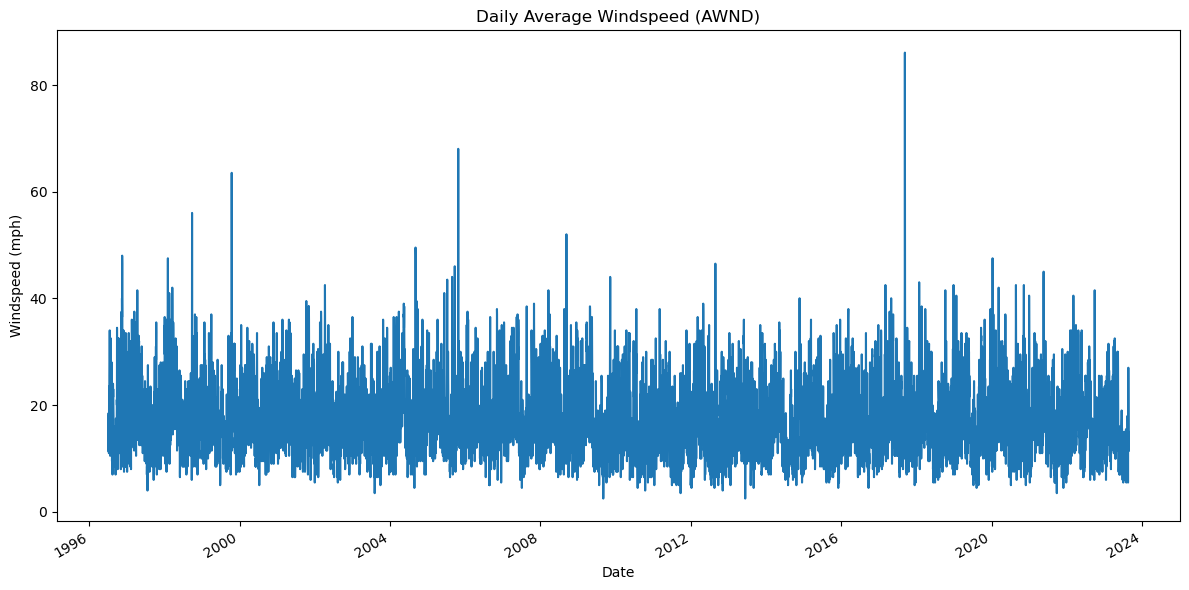

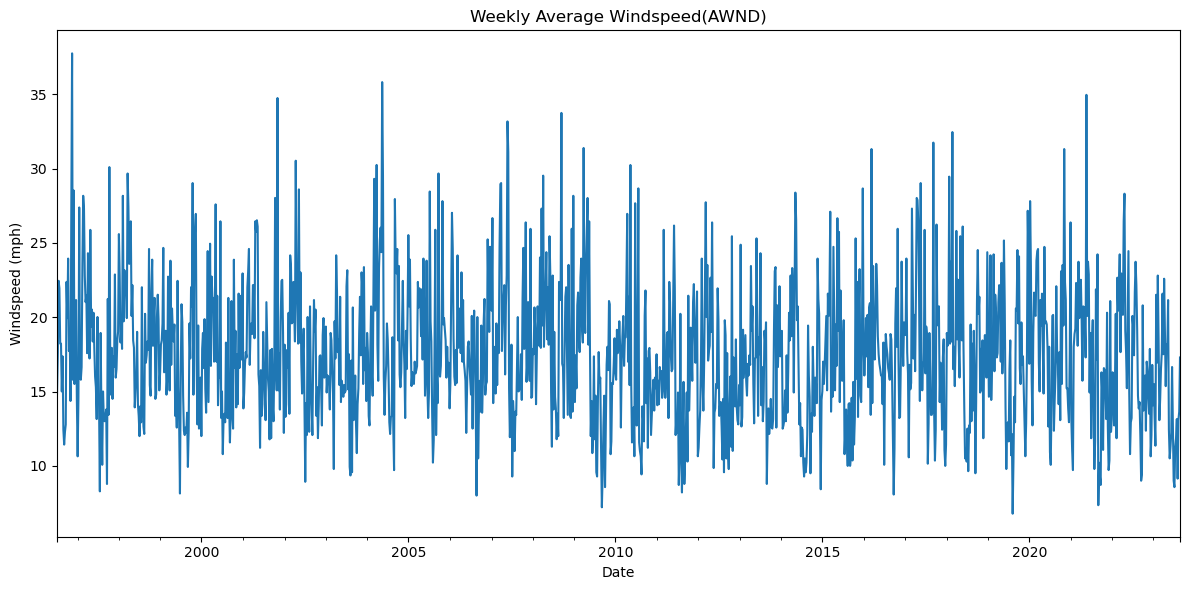

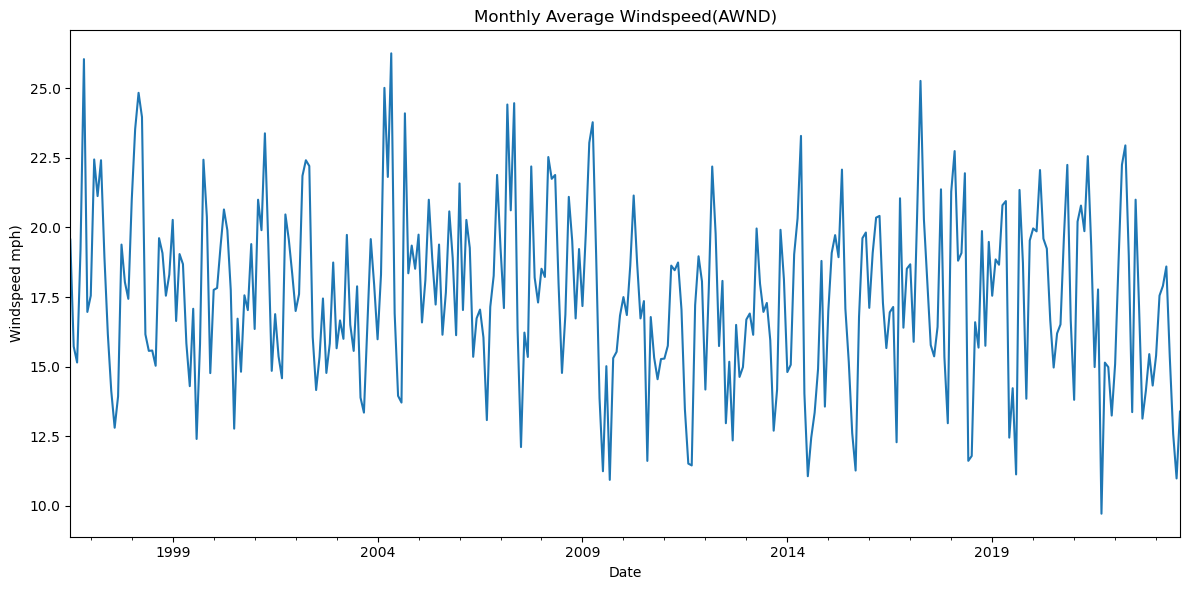

In [102]:
#Daily AWND (Average Daily Windspeed)
df['AWND_mph'].plot(figsize=(12,6))
plt.title('Daily Average Windspeed (AWND)')
plt.ylabel('Windspeed (mph)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

#weekly mean AWND
df['AWND_mph'].resample('W').mean().plot(figsize=(12,6))
plt.title('Weekly Average Windspeed(AWND)')
plt.ylabel('Windspeed (mph)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

#monthly mean AWND
monthly_mean_windspeed = df['AWND_mph'].resample('ME').mean()
monthly_mean_windspeed.plot(figsize=(12,6))
plt.title('Monthly Average Windspeed(AWND)')
plt.ylabel('Windspeed mph)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()




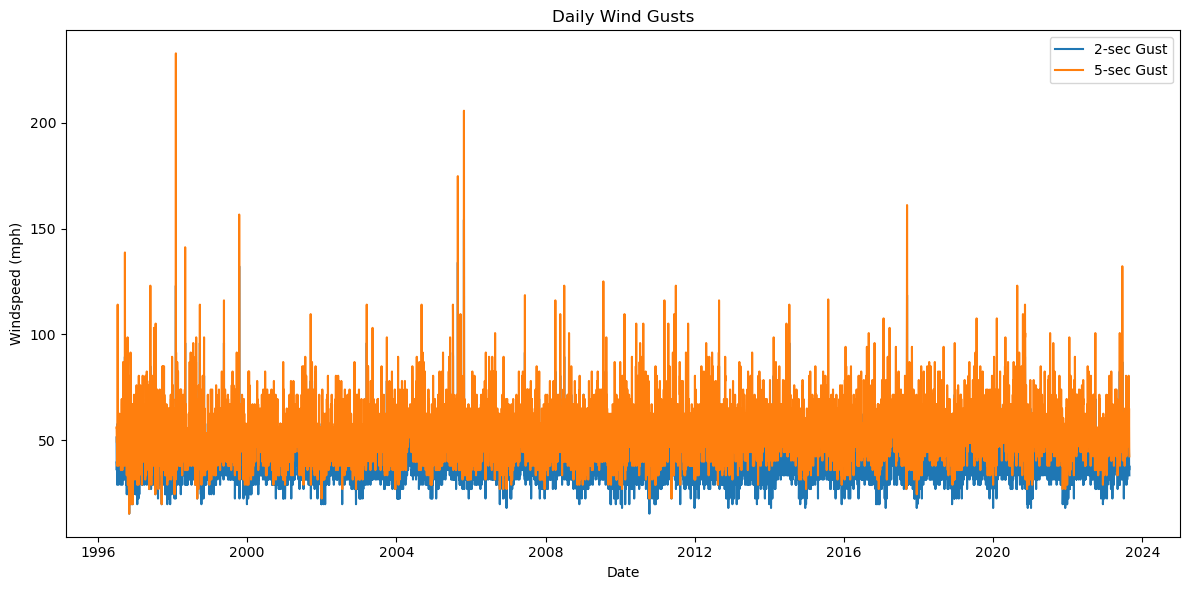

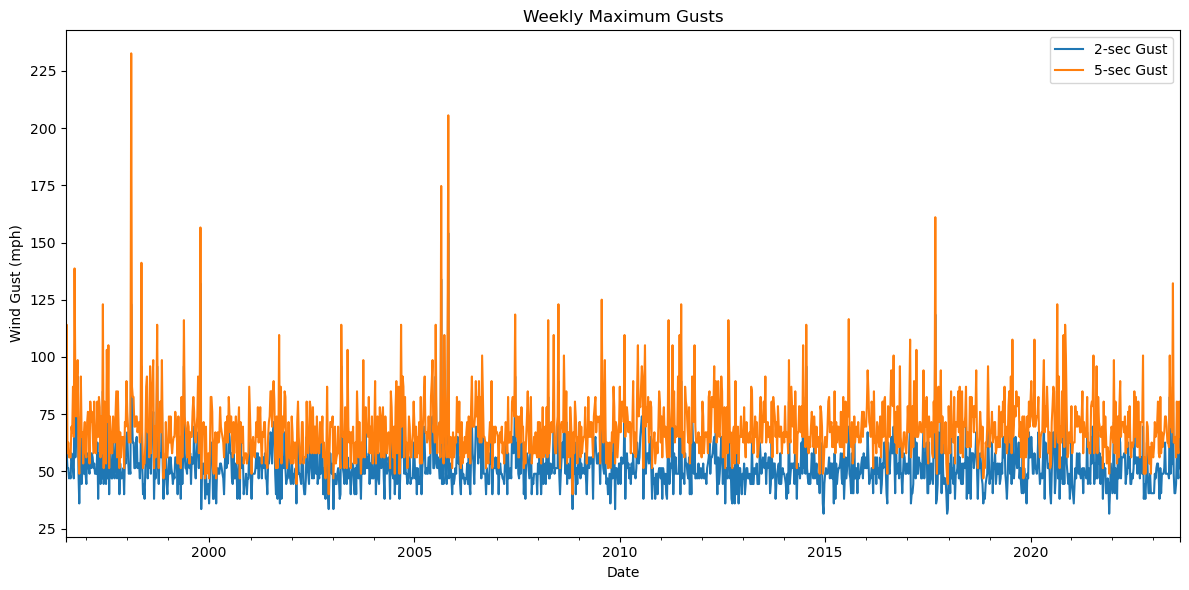

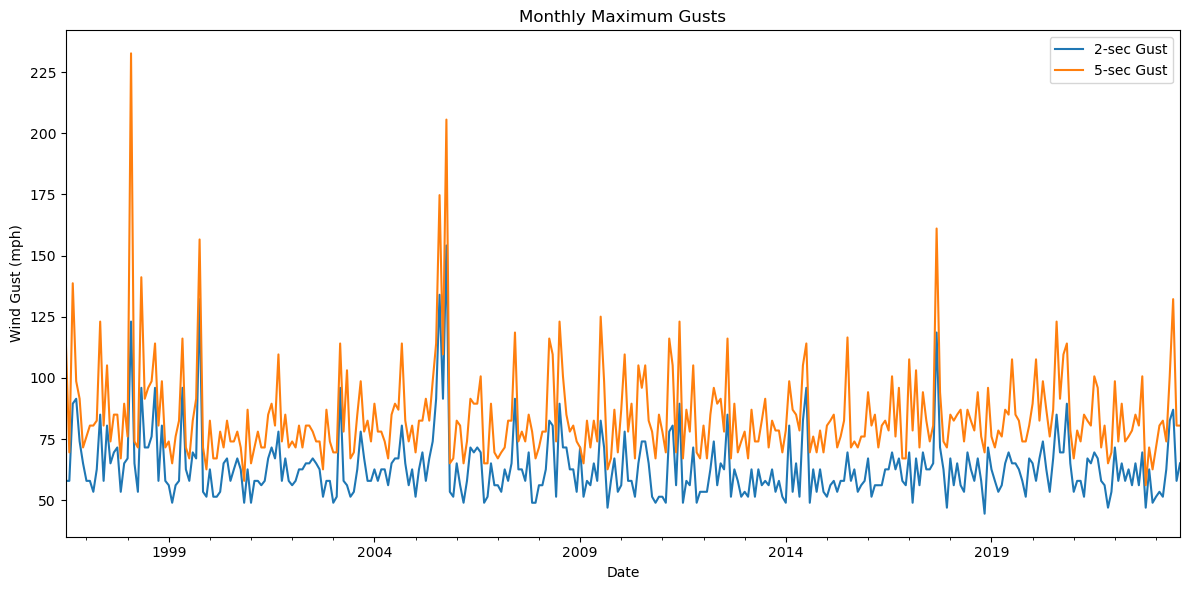

In [103]:
#daily/weekly/monthly Max Gusts (WSF2, WSF5)
#daily wind gusts
plt.figure(figsize=(12,6))
plt.plot(df.index, df['WSF2_mph'], label='2-sec Gust')
plt.plot(df.index, df['WSF5_mph'], label='5-sec Gust')
plt.title('Daily Wind Gusts')
plt.xlabel('Date')
plt.ylabel('Windspeed (mph)')
plt.legend()
plt.tight_layout()
plt.show()

#weekly max gusts
plt.figure(figsize=(12,6))
df['WSF2_mph'].resample('W').max().plot(label='2-sec Gust')
df['WSF5_mph'].resample('W').max().plot(label='5-sec Gust')
plt.title('Weekly Maximum Gusts')
plt.ylabel('Wind Gust (mph)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

#monthly Max Gusts
plt.figure(figsize=(12,6))
df['WSF2_mph'].resample('ME').max().plot(label='2-sec Gust')
df['WSF5_mph'].resample('ME').max().plot(label='5-sec Gust')
plt.title('Monthly Maximum Gusts')
plt.ylabel('Wind Gust (mph)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
#compare WSF2 vs WSF5 Gusts
df['gust_ratio'] = df['WSF2_mph'] / df['WSF5_mph']
average_ratio = df['gust_ratio'].mean()
print(f"Average ratio of 2-sec gusts to 5-sec gusts: {average_ratio:.2f}")

Average ratio of 2-sec gusts to 5-sec gusts: 0.76


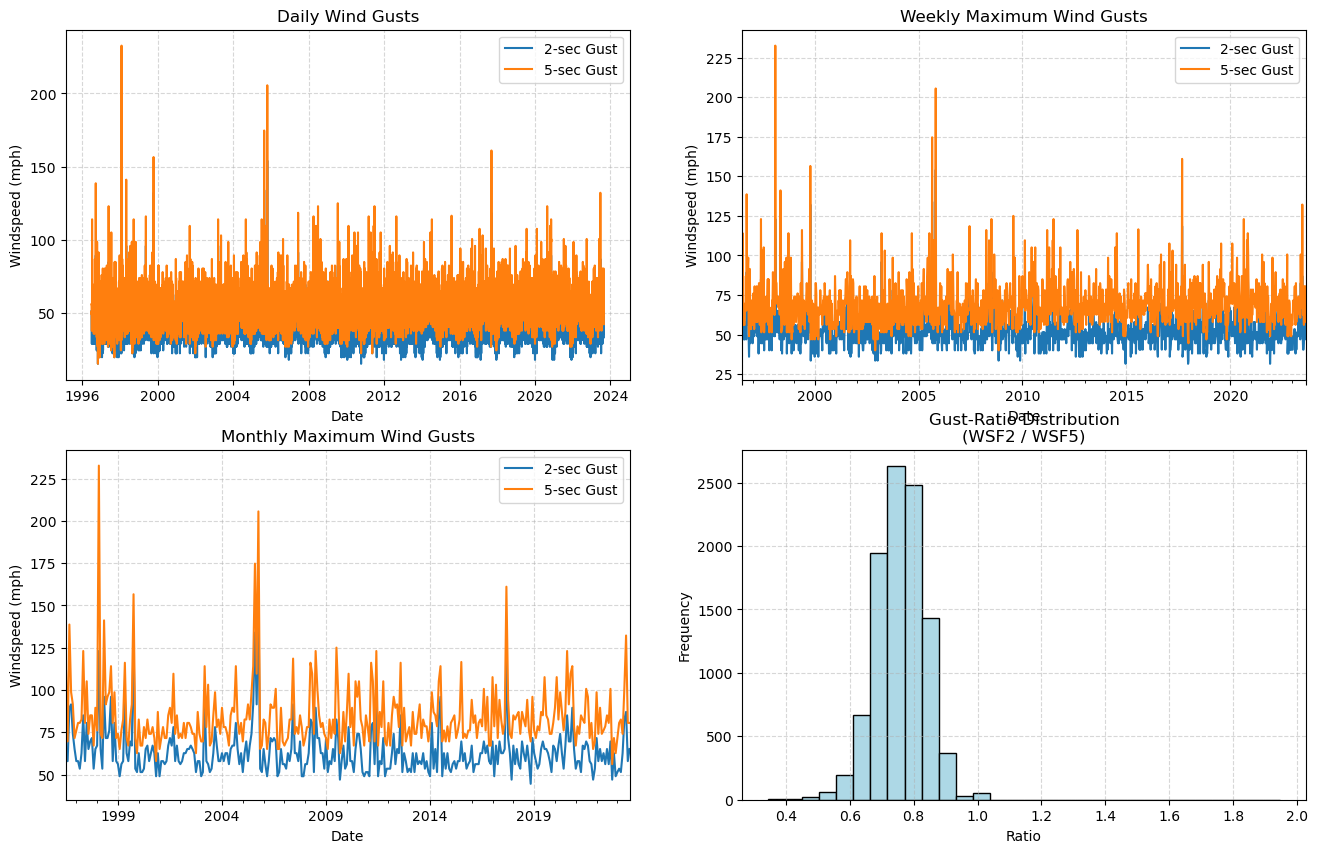

In [105]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows x 2 columns

# 1. Daily Wind Gusts
axes[0,0].plot(df.index, df['WSF2_mph'], label='2-sec Gust')
axes[0,0].plot(df.index, df['WSF5_mph'], label='5-sec Gust')
axes[0,0].set_title('Daily Wind Gusts')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Windspeed (mph)')
axes[0,0].legend()
axes[0,0].grid(True, linestyle='--', alpha=0.5)

# 2. Weekly Maximum Gusts
df['WSF2_mph'].resample('W').max().plot(ax=axes[0,1], label='2-sec Gust')
df['WSF5_mph'].resample('W').max().plot(ax=axes[0,1], label='5-sec Gust')
axes[0,1].set_title('Weekly Maximum Wind Gusts')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Windspeed (mph)')
axes[0,1].legend()
axes[0,1].grid(True, linestyle='--', alpha=0.5)

# 3. Monthly Maximum Gusts
df['WSF2_mph'].resample('ME').max().plot(ax=axes[1,0], label='2-sec Gust')
df['WSF5_mph'].resample('ME').max().plot(ax=axes[1,0], label='5-sec Gust')
axes[1,0].set_title('Monthly Maximum Wind Gusts')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Windspeed (mph)')
axes[1,0].legend()
axes[1,0].grid(True, linestyle='--', alpha=0.5)

# 4. Distribution of the 2-sec / 5-sec gust ratio
axes[1,1].hist(df['gust_ratio'].dropna(), bins=30,
               color='lightblue', edgecolor='black')
axes[1,1].set_title('Gust-Ratio Distribution\n(WSF2 / WSF5)')
axes[1,1].set_xlabel('Ratio')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, linestyle='--', alpha=0.5)
plt.show()




<Figure size 1000x500 with 0 Axes>

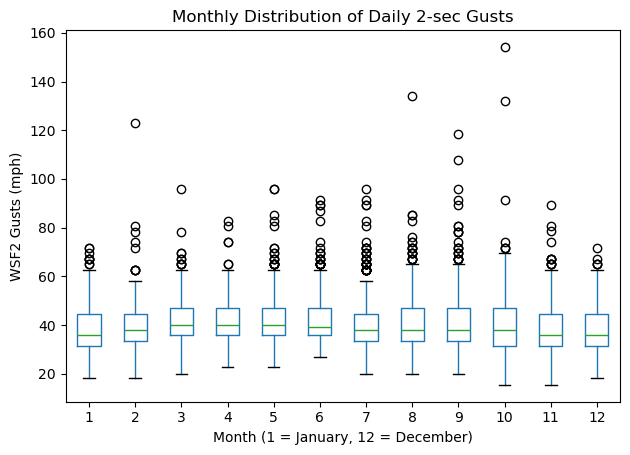

In [106]:
#----Monthly Box Plot to see Seasonal Trends -----#
# Drop NaNs to avoid issues
df_monthly = df[['WSF2_mph']].dropna().copy()
df_monthly['Month'] = df_monthly.index.month  # extract month number

# Plot boxplot
plt.figure(figsize=(10, 5))
df_monthly.boxplot(column='WSF2_mph', by='Month', grid=False)
plt.title('Monthly Distribution of Daily 2-sec Gusts')
plt.suptitle('')  # removes the default super title
plt.xlabel('Month (1 = January, 12 = December)')
plt.ylabel('WSF2 Gusts (mph)')
plt.tight_layout()
plt.show()

In [107]:
threshold_gust = df['WSF2_mph'].quantile(0.90) #top 10% of windspeeds
print(f"90th percentile threshold {threshold_gust:.2f} mph")

extreme_gusts = df[df['WSF2_mph'] > threshold_gust]
print(extreme_gusts.head())

90th percentile threshold 51.45 mph
                STATION                                NAME   AWND  PGTM  \
DATE                                                                       
1996-07-12  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US   6.26   NaN   
1996-08-19  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US   9.62   NaN   
1996-08-20  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US  10.29   NaN   
1996-08-21  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US   9.40   NaN   
1996-08-31  USW00012839  MIAMI INTERNATIONAL AIRPORT, FL US   4.25   NaN   

            PRCP  TAVG  TMAX  TMIN   WDF2   WDF5  WSF2  WSF5   AWND_mph  \
DATE                                                                      
1996-07-12  1.56   NaN  90.0    72  270.0  270.0  25.9  51.0  14.003244   
1996-08-19  0.73   NaN  89.0    72  100.0   90.0  23.9  29.1  21.519363   
1996-08-20  0.94   NaN  88.0    73  100.0   70.0  25.1  30.0  23.018113   
1996-08-21  0.06   NaN  89.0    73   90.0   90.0  25.9  

Stationary Testing

In [108]:
#Stationary Tests
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(x):
    adf_p = adfuller(x.dropna())[1]
    kpss_p = kpss(x.dropna(), nlags="auto")[1]
    print(f"ADF p-value = {adf_p:.3f}, KPSS p-value = {kpss_p:.3f}")

print("RAW Series:")
stationarity_tests(df['WSF2_mph'])
print("1x differenced:")       # raw
stationarity_tests(df['WSF2_mph'].diff())   # once‐differenced

RAW Series:
ADF p-value = 0.000, KPSS p-value = 0.088
1x differenced:
ADF p-value = 0.000, KPSS p-value = 0.100


/tmp/ipykernel_146300/3427023440.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(x.dropna(), nlags="auto")[1]


ARIMA Modeling

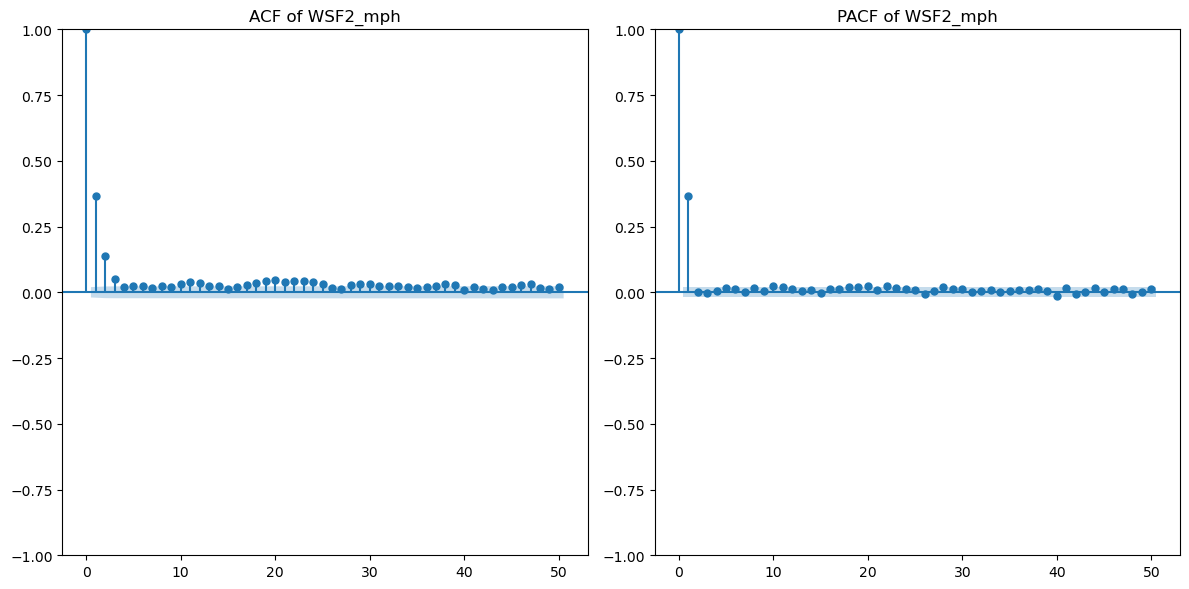

In [109]:
#Plot ACF and PACF of WSF2_mph
plt.figure(figsize=(12,6))
plt.subplot(121)
plot_acf(df['WSF2_mph'].dropna(), lags=50, ax=plt.gca())
plt.title('ACF of WSF2_mph')

plt.subplot(122)
plot_pacf(df['WSF2_mph'].dropna(), lags=50, ax=plt.gca())
plt.title('PACF of WSF2_mph')

plt.tight_layout()
plt.show()

In [110]:
#----DAILY ARIMA ----##
#train/test Gust data
gust_data = df['WSF2_mph'].dropna().asfreq('D')

#Train/Test Split
train_size = int(len(gust_data) * 0.8) # 80 % training
train = gust_data.iloc[:train_size]
test = gust_data.iloc[train_size:]

print(f"Training size: {len(train)}, Testing size: {len(test)}")
gust_data.describe()


Training size: 7935, Testing size: 1984


count    9916.000000
mean       40.046189
std         9.561041
min        15.434886
25%        33.554100
50%        38.027980
75%        46.975740
max       154.125166
Name: WSF2_mph, dtype: float64

In [111]:
#ARIMA Grid Search
# Define models to compare
models = {
    'ARIMA(1,1,1)': (1,1,1),
    'ARIMA(0,1,1)': (0,1,1),
    'ARIMA(0,0,1)': (0,0,1),
    'ARIMA(1,0,0)': (1,0,0),
    'ARIMA(1,1,0)': (1,1,0),
    'ARIMA(1,0,1)': (1,0,1),
    'ARIMA(2,1,2)': (2,1,2),
    'ARIMA(2,0,0)': (2,0,0),
    'ARIMA(2,0,2)': (2,0,2),
    'ARIMA(0,0,1)+drift': (0,0,1),
    'ARIMA(1,1,1)+drift':(1,1,1)
}

results = {}

# Fit each model and store AIC
for name, order in models.items():
    try:
        if '+drift' in name:
            model = ARIMA(gust_data, order = order, trend='t') #linear drift
        else:
            model = ARIMA(train, order=order)
        fitted = model.fit()
        results[name] = (fitted.aic, fitted.bic)
        print(f"{name:17} - AIC: {fitted.aic:.2f}, BIC: {fitted.bic:.2f}")
    except Exception as e:
        print(f"{name} - Failed to fit: {e}")

# Find the model with the lowest AIC
best_model = min(results, key=lambda k: results[k][0])
print(f"\nBest model based on AIC: {best_model}")

ARIMA(1,1,1)      - AIC: 57439.67, BIC: 57460.60
ARIMA(0,1,1)      - AIC: 58360.59, BIC: 58374.55
ARIMA(0,0,1)      - AIC: 57562.23, BIC: 57583.17
ARIMA(1,0,0)      - AIC: 57441.76, BIC: 57462.70
ARIMA(1,1,0)      - AIC: 59645.80, BIC: 59659.75
ARIMA(1,0,1)      - AIC: 57443.76, BIC: 57471.68
ARIMA(2,1,2)      - AIC: 57442.20, BIC: 57477.09
ARIMA(2,0,0)      - AIC: 57443.76, BIC: 57471.68
ARIMA(2,0,2)      - AIC: 57447.72, BIC: 57489.59
ARIMA(0,0,1)+drift - AIC: 82788.40, BIC: 82810.01
ARIMA(1,1,1)+drift - AIC: 71463.68, BIC: 71492.49

Best model based on AIC: ARIMA(1,1,1)


In [112]:
#fit ARIMA on Training Set and Predict on Test Set
#fit ARIMA on training data
model = ARIMA(train, order=(1,1,1))
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:               WSF2_mph   No. Observations:                 7935
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -28716.834
Date:                Thu, 01 May 2025   AIC                          57439.668
Time:                        15:16:10   BIC                          57460.605
Sample:                    07-01-1996   HQIC                         57446.837
                         - 03-22-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3543      0.007     50.450      0.000       0.341       0.368
ma.L1         -0.9990      0.001  -1696.892      0.000      -1.000      -0.998
sigma2        81.6260      0.577    141.582      0.0

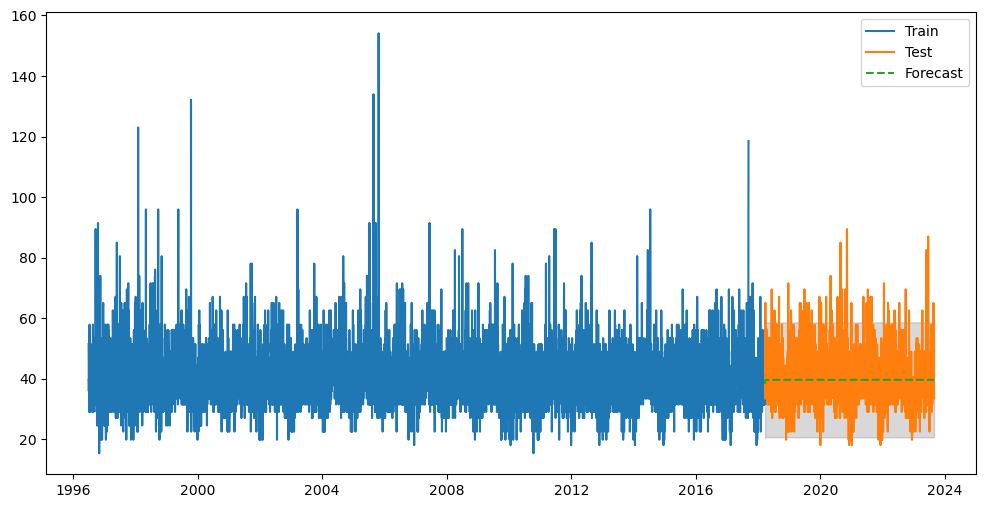

In [113]:
#Forecast & Residuals with Confidence Intervals 95% band
fc = fitted_model.get_forecast(steps=len(test))
ci = fc.conf_int(alpha=0.05)
ci.index = test.index

plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(fc.predicted_mean, "--", label="Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="gray", alpha=0.3)
plt.legend()

In [114]:
#residuals #out of sample
residuals = test - fc.predicted_mean
print(residuals.describe())

#inject noise into forecast
noise = np.random.choice(residuals.dropna(), size=len(test), replace=True)
forecast_with_noise = fc.predicted_mean + noise

print(f"Test NaNs: {test.isna().sum()}")
print(f"Forecast NaNs: {forecast_with_noise.isna().sum()}")

#Evaluate Forecast
#drop NaNs
test_clean = test.dropna()
forecast_clean = forecast_with_noise.dropna()

#align indexes
common_index = test_clean.index.intersection(forecast_clean.index)
test_clean = test_clean.loc[common_index]
forecast_clean = forecast_clean.loc[common_index]

#make sure same length
print(f"Final Test Length: {len(test_clean)}, Forecast Length: {len(forecast_clean)}")

#calculate errors
mse = mean_squared_error(test_clean, forecast_clean)
mae = mean_absolute_error(test_clean, forecast_clean)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")


count    1983.000000
mean        0.423875
std         9.136209
min       -21.567288
25%        -6.132402
50%        -1.658522
75%         7.289238
max        49.791098
dtype: float64
Test NaNs: 1
Forecast NaNs: 0
Final Test Length: 1983, Forecast Length: 1983
Test MSE: 171.79
Test MAE: 10.11
Test RMSE: 13.11


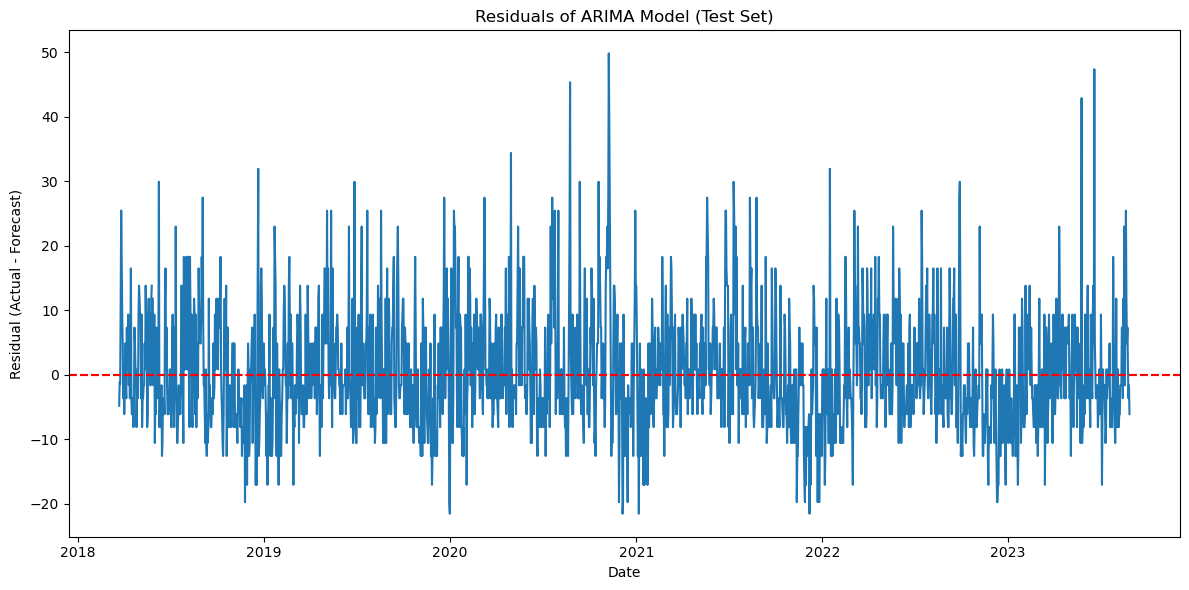

In [115]:
#plot residuals
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model (Test Set)')
plt.axhline(0, color='red', linestyle="--")
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Forecast)')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

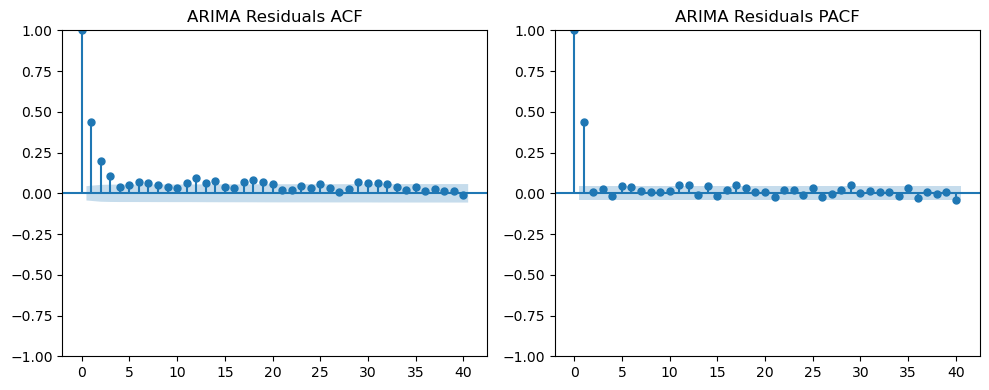

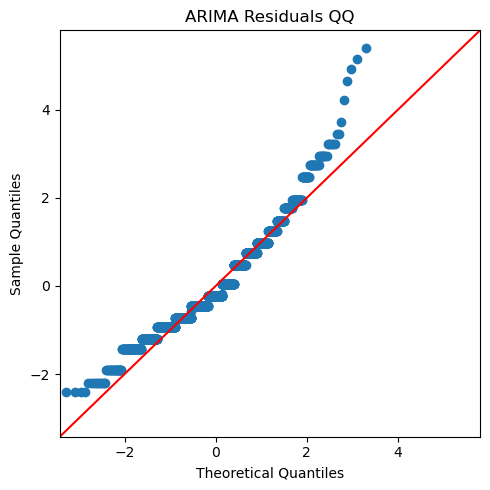

       lb_stat      lb_pvalue
10  511.879348  1.276336e-103


In [116]:
#------ARIMA Residual Diagnostics -------#

# 1) ACF/PACF of residuals
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_acf(residuals.dropna(), lags=40, ax=plt.gca())
plt.title("ARIMA Residuals ACF")
plt.subplot(122)
plot_pacf(residuals.dropna(), lags=40, ax=plt.gca())
plt.title("ARIMA Residuals PACF")
plt.tight_layout()

# 2) QQ-plot
plt.figure(figsize=(5,5))
qqplot(residuals.dropna(), line="45", fit=True, ax=plt.gca())
plt.title("ARIMA Residuals QQ")
plt.tight_layout()
plt.show()

# 3) Ljung–Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(residuals.dropna(), lags=[10], return_df=True)
print(lb)


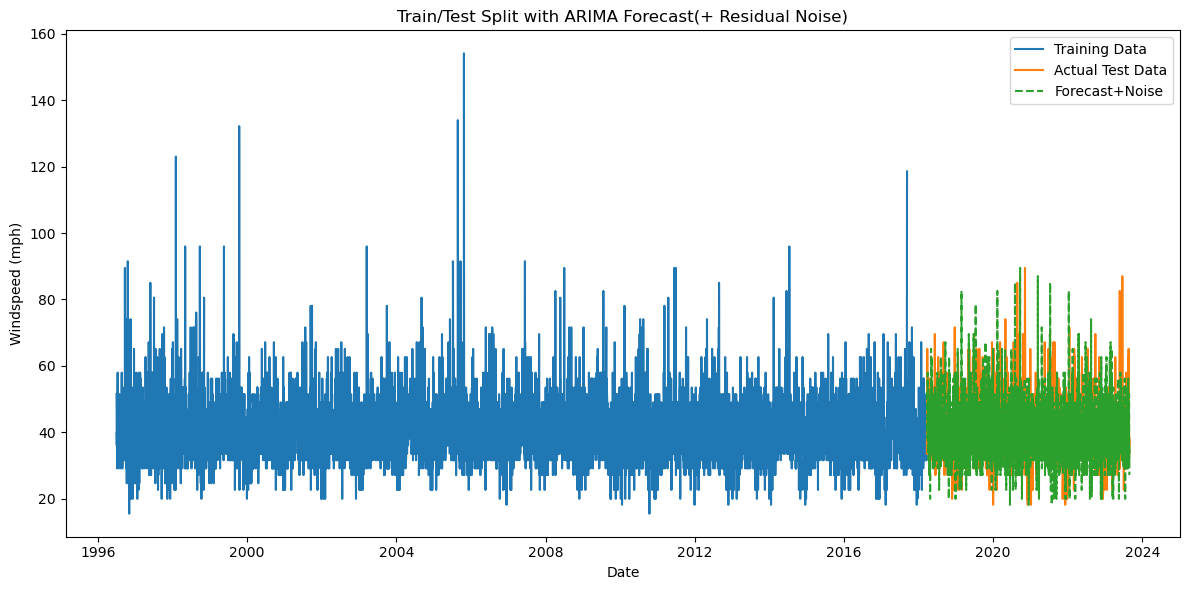

In [76]:
#plot Actual vs Forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast_with_noise, label='Forecast+Noise', linestyle='--')
plt.title('Train/Test Split with ARIMA Forecast(+ Residual Noise)')
plt.xlabel('Date')
plt.ylabel('Windspeed (mph)')
plt.legend()
plt.tight_layout()
plt.show()

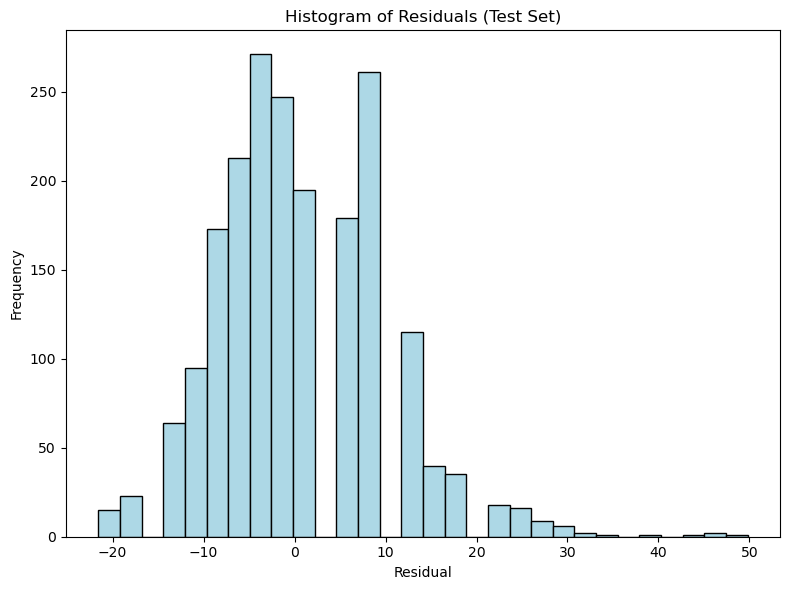

In [77]:
#histogram of residuals (check if errors are normally distributed)
plt.figure(figsize=(8,6))
plt.hist(residuals.dropna(), bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Residuals (Test Set)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [117]:
#Refit ARIMA on FULL Gust DAta to forecast future
full_model = ARIMA(gust_data, order=(1,1,1))
full_fitted = full_model.fit()

#forecast next 365 days (1 year)
future_forecast_obj = full_fitted.get_forecast(steps=1825)
future_forecast = future_forecast_obj.predicted_mean

#create future dates
future_index = pd.date_range(start=gust_data.index[-1] + pd.Timedelta(days=1), periods=1825, freq='D')
future_forecast.index = future_index

#inject residual noise into future forecast
future_noise = np.random.choice(residuals.dropna(), size=len(future_forecast),replace=True )
future_forecast_with_noise = future_forecast + future_noise

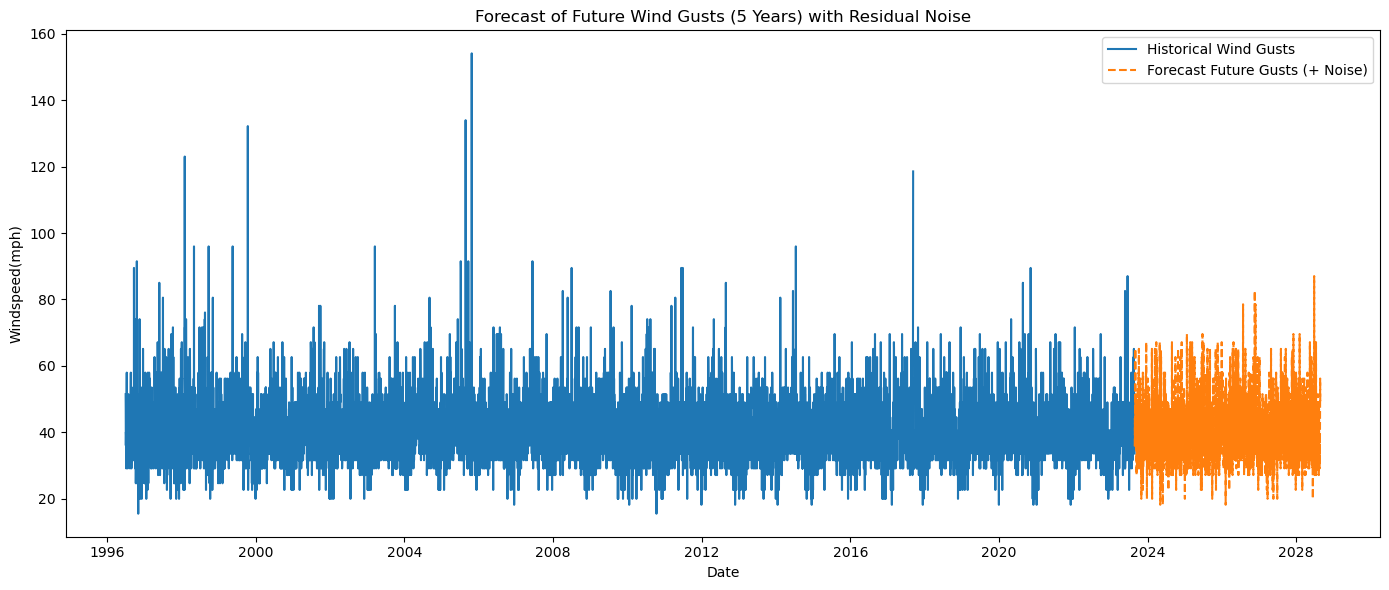

In [118]:
#plot Historical + future forecast 
plt.figure(figsize=(14,6))
plt.plot(gust_data.index, gust_data, label='Historical Wind Gusts')
plt.plot(future_forecast_with_noise.index, future_forecast_with_noise, label='Forecast Future Gusts (+ Noise)', linestyle='--')
plt.title('Forecast of Future Wind Gusts (5 Years) with Residual Noise')
plt.xlabel('Date')
plt.ylabel('Windspeed(mph)')
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
#check values
print(future_forecast.describe())
print(future_forecast.head(10)) #first 10
print(future_forecast.tail(10)) #last 10
print(f"Forecast Mean: {future_forecast.mean():.2f}")
print(f"Forecast Std Dev: {future_forecast.std():.2f}")

print(future_forecast_with_noise.head(10)) #first 10
print(future_forecast_with_noise.tail(10)) #last 10
print(f"Forecast + Noise Mean: {future_forecast_with_noise.mean():.2f}")
print(f"Forecast + Noise Std Dev: {future_forecast_with_noise.std():.2f}")

count    1825.000000
mean       39.695123
std         0.057064
min        37.430577
25%        39.697091
50%        39.697091
75%        39.697091
max        39.697091
Name: predicted_mean, dtype: float64
2023-08-28    37.430577
2023-08-29    38.860839
2023-08-30    39.388548
2023-08-31    39.583251
2023-09-01    39.655088
2023-09-02    39.681594
2023-09-03    39.691373
2023-09-04    39.694981
2023-09-05    39.696312
2023-09-06    39.696803
Freq: D, Name: predicted_mean, dtype: float64
2028-08-16    39.697091
2028-08-17    39.697091
2028-08-18    39.697091
2028-08-19    39.697091
2028-08-20    39.697091
2028-08-21    39.697091
2028-08-22    39.697091
2028-08-23    39.697091
2028-08-24    39.697091
2028-08-25    39.697091
Freq: D, Name: predicted_mean, dtype: float64
Forecast Mean: 39.70
Forecast Std Dev: 0.06
2023-08-28    33.758809
2023-08-29    30.715191
2023-08-30    33.256146
2023-08-31    37.924729
2023-09-01    40.457201
2023-09-02    44.510198
2023-09-03    44.519977
2023-09-04 

In [81]:
#Compare WSF2 to WSF5
for col,label in [('WSF2_mph','WSF2'),('WSF5_mph','WSF5')]:
    data = df[col].dropna().asfreq('D')
    train, test = data[:train_size], data[train_size:]
    m = ARIMA(train, order=(1,1,1), trend='n').fit()
    pr = m.forecast(steps=len(test))
  

    #align truth prediction, drop any NANs
    y_true = test.dropna()
    y_pred = pr.reindex(y_true.index) #match index
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(label, "ARIMA(1,1,1) RMSE:", rmse)


WSF2 ARIMA(1,1,1) RMSE: 9.143735334174725
WSF5 ARIMA(1,1,1) RMSE: 11.830657010987165


SARIMA Modeling

Monthly SARIMA 12 Month Season

In [119]:
# --- Monthly SARIMA (12-month season) ---
from statsmodels.tsa.seasonal import seasonal_decompose

# first valid gust is
first = df['WSF2_mph'].first_valid_index()
print("First available daily gust on:", first)

# Monthly max gust series
monthly_gust = df['WSF2_mph'].resample('ME').max().dropna()

# start at Jan 1997
monthly_gust = monthly_gust[monthly_gust.index >= '1997-01-01']


First available daily gust on: 1996-07-01 00:00:00


In [120]:
# 4) Stationarity tests
def stationarity_tests(x):
    adf_p = adfuller(x)[1]
    kpss_p = kpss(x, nlags="auto")[1]
    print(f"ADF p-value={adf_p:.3f}, KPSS p-value={kpss_p:.3f}")

print("\nStationarity of raw monthly:")
stationarity_tests(monthly_gust)
print("\nStationarity of 1× differenced monthly:")
stationarity_tests(monthly_gust.diff().dropna())



Stationarity of raw monthly:
ADF p-value=0.000, KPSS p-value=0.088

Stationarity of 1× differenced monthly:
ADF p-value=0.000, KPSS p-value=0.100


/tmp/ipykernel_146300/2416944150.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(x, nlags="auto")[1]


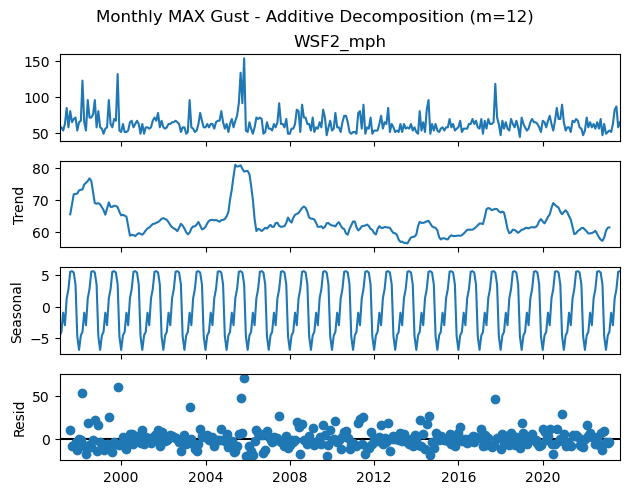

In [84]:
# 5) Seasonal decomposition (12-month)
decomp = seasonal_decompose(monthly_gust, model='additive', period=12)
decomp.plot()
plt.suptitle("Monthly MAX Gust - Additive Decomposition (m=12)", y=1.02)
plt.show()

In [121]:
# 6) SARIMA grid search over p,d,q∈{0,1}, seasonal P,D,Q∈{0,1}, m=12
p = d = q = [0,1]
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(P,D,Q,12) for P in [0,1] for D in [0,1] for Q in [0,1]]

best_aic = np.inf
best_cfg = None

print("\nSearching SARIMA(p,d,q)x(P,D,Q,12)…")
for order in pdq:
    for sorder in seasonal_pdq:
        try:
            mod = SARIMAX(
                monthly_gust,
                order=order,
                seasonal_order=sorder,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = mod.fit(disp=False)
            if res.aic < best_aic:
                best_aic, best_cfg = res.aic, (order, sorder)
            print(f"SARIMA{order}x{sorder}12 – AIC:{res.aic:.0f}")
        except:
            continue

print(f"\n>> Best SARIMA: order={best_cfg[0]} seasonal={best_cfg[1]}, AIC={best_aic:.0f}")


Searching SARIMA(p,d,q)x(P,D,Q,12)…
SARIMA(0, 0, 0)x(0, 0, 0, 12)12 – AIC:3568
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 – AIC:3170
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 – AIC:2661
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 – AIC:2372
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 – AIC:2664


/home/allana/miniconda3/envs/arima_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 0)x(1, 0, 1, 12)12 – AIC:2480
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 – AIC:2470
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 – AIC:2374
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 – AIC:3267
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 – AIC:2992
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 – AIC:2640
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 – AIC:2361
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 – AIC:2663


/home/allana/miniconda3/envs/arima_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 – AIC:2473
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 – AIC:2469
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 – AIC:2363
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 – AIC:2716
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 – AIC:2608
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 – AIC:2830
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 – AIC:2533
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 – AIC:2627
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 – AIC:2601
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 – AIC:2632
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 – AIC:2535
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 – AIC:2553
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 – AIC:2454
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 – AIC:2646
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 – AIC:2354
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 – AIC:2479
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 – AIC:2451
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 – AIC:2470
SARIMA(0, 1, 1)x(1, 1, 1, 12)12 – AIC:2356
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 – AIC:2720
SARIMA(1, 0, 0)x(0, 0, 1, 12)12 – AIC:2623
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 – AIC:2660
SARIMA(1, 0, 0)x(0, 1, 1, 12)12 – AIC:2371
SARIMA(1, 0

/home/allana/miniconda3/envs/arima_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1, 0, 1, 12)12 – AIC:2469
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 – AIC:2459
SARIMA(1, 0, 1)x(1, 1, 1, 12)12 – AIC:2359
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 – AIC:2633
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 – AIC:2527
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 – AIC:2738
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 – AIC:2447
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 – AIC:2527
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 – AIC:2528
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 – AIC:2530
SARIMA(1, 1, 0)x(1, 1, 1, 12)12 – AIC:2449
SARIMA(1, 1, 1)x(0, 0, 0, 12)12 – AIC:2547
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 – AIC:2445
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 – AIC:2645
SARIMA(1, 1, 1)x(0, 1, 1, 12)12 – AIC:2355
SARIMA(1, 1, 1)x(1, 0, 0, 12)12 – AIC:2457
SARIMA(1, 1, 1)x(1, 0, 1, 12)12 – AIC:2442
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 – AIC:2457
SARIMA(1, 1, 1)x(1, 1, 1, 12)12 – AIC:2357

>> Best SARIMA: order=(0, 1, 1) seasonal=(0, 1, 1, 12), AIC=2354


In [30]:
#SPLit Train and Test
n_test = 24 #last 24m held out
train_monthly = monthly_gust[:-n_test]
test_monthly = monthly_gust[-n_test:]

In [86]:
# 7) Fit best SARIMA on training only
order, sorder = best_cfg

sar_train_res = SARIMAX(
        train_monthly,
        order=order,
        seasonal_order=sorder,
        enforce_stationarity=False,
        enforce_invertibility=False).fit(disp=False)

print(sar_train_res.summary())


                                     SARIMAX Results                                      
Dep. Variable:                           WSF2_mph   No. Observations:                  296
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1082.992
Date:                            Tue, 29 Apr 2025   AIC                           2171.985
Time:                                    20:13:26   BIC                           2182.769
Sample:                                01-31-1997   HQIC                          2176.316
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9457      0.018    -53.359      0.000      -0.980      -0.911
ma.S.L12      -1.0000    226.067   

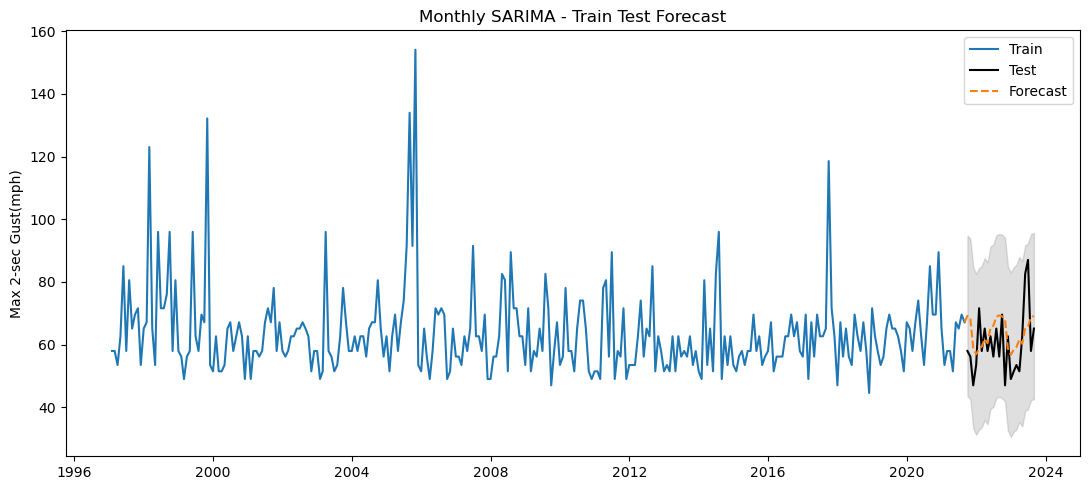

In [87]:
#forecast test window
fc = sar_train_res.get_forecast(steps=n_test)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()
fc_mean.index = fc_ci.index = test_monthly.index
fc_mean_cont = pd.concat([train_monthly.iloc[-1:], fc_mean])

plt.figure(figsize=(11,5))
plt.plot(train_monthly, label='Train')
plt.plot(test_monthly, label='Test', color='k')
plt.plot(fc_mean_cont, '--', label='Forecast')
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1],
                 color='gray', alpha=0.25)
plt.title("Monthly SARIMA - Train Test Forecast")
plt.ylabel("Max 2-sec Gust(mph)")
plt.legend()
plt.tight_layout()
plt.show()

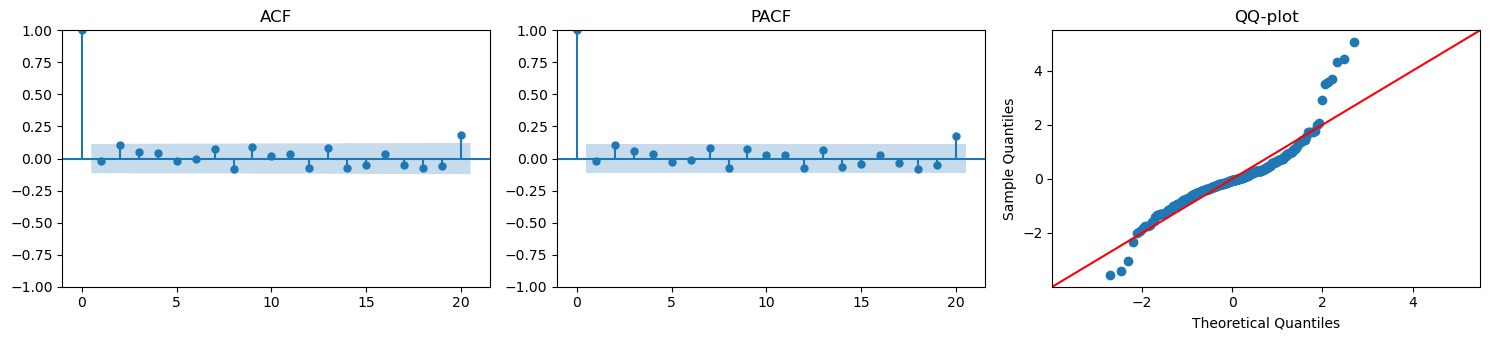

Ljung-Box p-value (lag-12): 0.358


In [122]:
#Residual diagnotistic (train fit)
monthly_resid_train = sar_train_res.resid.dropna()

# plot ACF/PACF of the residuals QQ plot
fig, axs = plt.subplots(1,3, figsize=(15,3.5))
plot_acf (monthly_resid_train, lags=20, ax=axs[0]); axs[0].set_title("ACF")
plot_pacf(monthly_resid_train, lags=20, ax=axs[1]); axs[1].set_title("PACF")
qqplot(monthly_resid_train, line='45', fit=True, ax=axs[2]); axs[2].set_title("QQ-plot")
plt.tight_layout(); plt.show()

pval_lb = acorr_ljungbox(monthly_resid_train, lags=[12], return_df=True)['lb_pvalue'].iloc[0]
print(f"Ljung-Box p-value (lag-12): {pval_lb:.3f}")


OOS residuals summary:
count    24.000000
mean     -3.193981
std       9.882468
min     -20.953839
25%     -10.311728
50%      -3.910128
75%       1.041933
max      21.200028
dtype: float64


<Figure size 800x300 with 0 Axes>

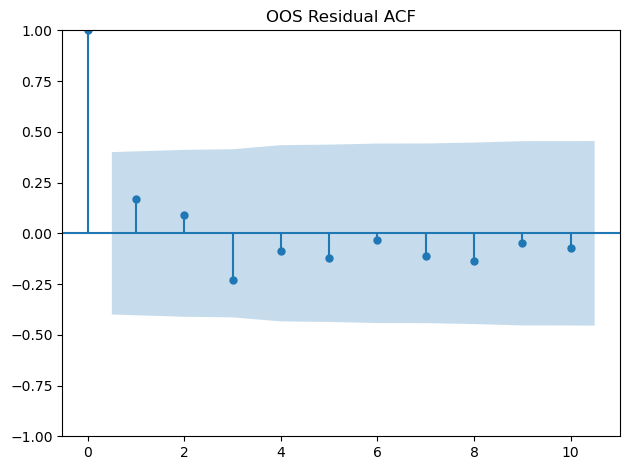

In [123]:
#out of sample residuals
monthly_resid_oos = test_monthly - fc_mean
print("\nOOS residuals summary:"); print(monthly_resid_oos.describe())

plt.figure(figsize=(8,3))
plot_acf(monthly_resid_oos.dropna(), lags=min(10, len(monthly_resid_oos)//2-1))
plt.title("OOS Residual ACF")
plt.tight_layout()
plt.show()

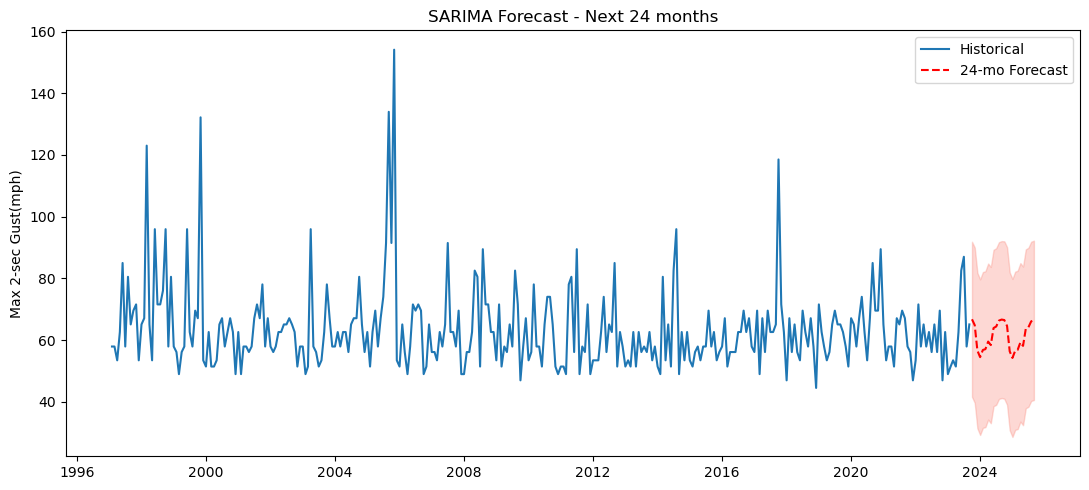

In [124]:
#Fit on Full sample and forecast next 24 months
sar_res_monthly = SARIMAX(
        monthly_gust,
        order = best_cfg[0],
        seasonal_order=best_cfg[1],
        enforce_stationarity=False,
        enforce_invertibility=False).fit(disp=False)

future_fc = sar_res_monthly.get_forecast(steps=24)
future_mean = future_fc.predicted_mean
future_ci = future_fc.conf_int()
future_mean.index = future_ci.index = pd.date_range(monthly_gust.index[-1] + pd.offsets.MonthEnd(),
                                                    periods=24, freq='ME')
plt.figure(figsize=(11,5))
plt.plot(monthly_gust, label='Historical')
plt.plot(future_mean, 'r--', label='24-mo Forecast')
plt.fill_between(future_ci.index, future_ci.iloc[:,0], future_ci.iloc[:,1],
                 color='salmon', alpha=0.3)
plt.title("SARIMA Forecast - Next 24 months")
plt.ylabel("Max 2-sec Gust(mph)")
plt.legend()
plt.tight_layout()
plt.show()

In [125]:
#RMSE Comparison
rmse_monthly = np.sqrt(mean_squared_error(test_monthly, fc_mean))
print(f"\nDaily ARIMA RMSE: {rmse:.2f}")
print(f"Monthly SARIMA RMSE: {rmse_monthly:.2f}")


Daily ARIMA RMSE: 13.11
Monthly SARIMA RMSE: 10.19


GEV FItting and Return Level

Shape: 0.0305, Location: 35.89, Scale:7.74


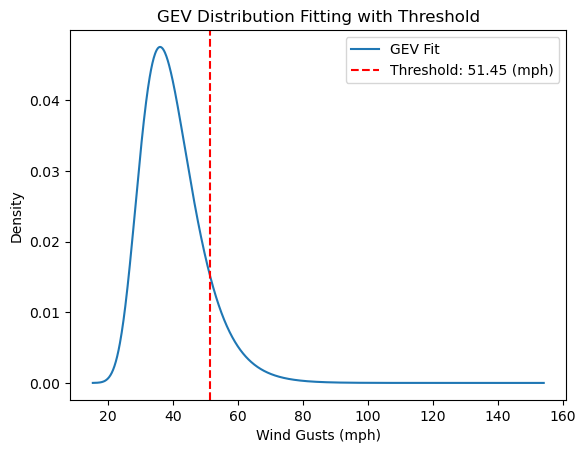

In [126]:
#DAILY GEV Diagnostics
#Fit GEV to max wind gust WSF2
params = stats.genextreme.fit(gust_data.dropna().values)

#extract fitted parameters: shape, location, scale
shape, loc, scale = params

#print fitted parameters
print(f"Shape: {shape:.4f}, Location: {loc:.2f}, Scale:{scale:.2f}")

#define threshold ( 90th percentile?)
threshold_gust = np.percentile(gust_data.dropna().values, 90)

#plot the GEV distribution with threshold
x = np.linspace(gust_data.min(), gust_data.max(), 1000)
pdf = stats.genextreme.pdf(x, shape, loc, scale)

plt.plot(x, pdf, label="GEV Fit")
plt.axvline(threshold_gust, color = 'r', linestyle='--', label=f"Threshold: {threshold_gust:.2f} (mph)")
plt.legend()
plt.title("GEV Distribution Fitting with Threshold")
plt.xlabel("Wind Gusts (mph)")
plt.ylabel("Density")
plt.show()

(<matplotlib.legend.Legend at 0x7f2b7110ec30>, Text(0.5, 1.0, 'GEV PP-plot'))

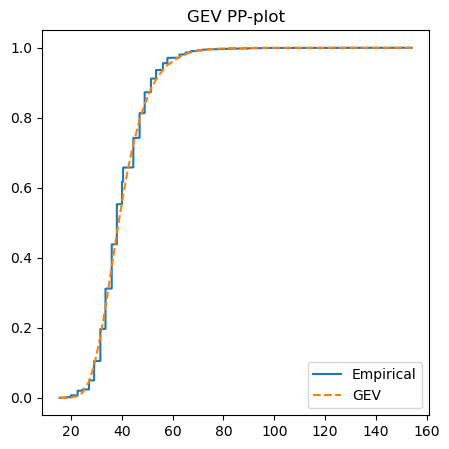

In [95]:
#DAILY GEV Diagnostics
# PP‐plot for daily GEV
from statsmodels.distributions.empirical_distribution import ECDF

sorted_gust = np.sort(gust_data.dropna())
gev_cdf = stats.genextreme.cdf(sorted_gust, *params)

emp_cdf = ECDF(gust_data.dropna())

plt.figure(figsize=(5,5))
plt.plot(emp_cdf.x, emp_cdf.y, label="Empirical")
plt.plot(sorted_gust, gev_cdf, "--", label="GEV")
plt.legend(), plt.title("GEV PP-plot")


Text(0.5, 1.0, 'Return‐Level Plot')

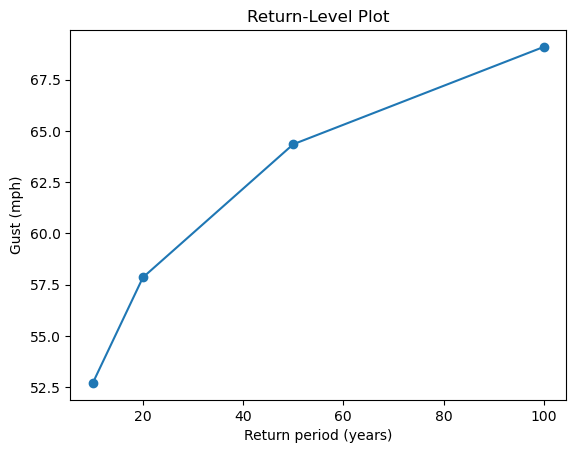

In [96]:

# Return‐level
rl = stats.genextreme.ppf(1 - 1/np.array([10,20,50,100]), *params)
plt.plot([10,20,50,100], rl, "o-")
plt.xlabel("Return period (years)"), plt.ylabel("Gust (mph)")
plt.title("Return‐Level Plot")

In [97]:
#MONTHLY GEVD & Histogram
#Calculate MLE for GEVD Shape K, location mu, scale sigma
monthly_max = df['WSF2_mph'].resample('ME').max().dropna() #wind gust data

#fit GEVD to data
shape, loc, scale = stats.genextreme.fit(monthly_max.values)


#print fitted params MLE
print(f"shape parameter (k): {shape:.4f}")
print(f"Location parameter (mu): {loc:.2f}")
print(f"Scale parameter (sigma): {scale:.2f}")

shape parameter (k): -0.1686
Location parameter (mu): 57.48
Scale parameter (sigma): 7.72


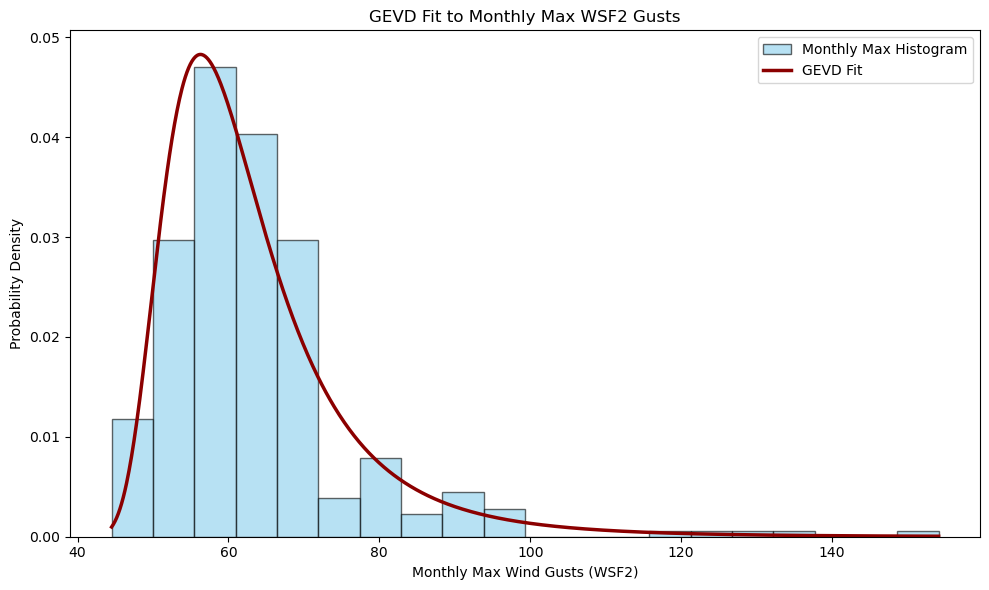

100-year return level (approx.): 111.15


In [40]:
#Visualize fitted MONTHLY GEVD
#plot histogram of data (wind gusts)
plt.figure(figsize=(10,6))
plt.hist(monthly_max, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Monthly Max Histogram")

#plot fitted GEVD PDF
x = np.linspace(monthly_max.min(), monthly_max.max(), 1000)
pdf = stats.genextreme.pdf(x, shape, loc=loc, scale=scale)
plt.plot(x, pdf, 'darkred', lw=2.5, label="GEVD Fit")

plt.title('GEVD Fit to Monthly Max WSF2 Gusts')
plt.xlabel("Monthly Max Wind Gusts (WSF2)")
plt.ylabel("Probability Density")
plt.legend()
plt.tight_layout()
plt.show()

#100 Year Return level
return_level_100 = stats.genextreme.ppf(0.99, shape, loc=loc, scale=scale)
print(f"100-year return level (approx.): {return_level_100:.2f}")


Parametric Insurance PAyouts

In [127]:
#parametric insurance trigger
#set payout trigger
payout_threshold = 50 #mph gust
df['trigger_event'] = df['WSF2_mph'] > payout_threshold

#total number of trigger events
trigger_count = df['trigger_event'].sum()
print(f"Total number of insurance trigger events: {trigger_count}")

#total hypothetical payout
payout_per_event = 10000 # $10,000 payout per event
total_payout = trigger_count * payout_per_event
print(f"Total hypothetical payouts: ${total_payout}")

Total number of insurance trigger events: 1261
Total hypothetical payouts: $12610000
